This notebook is used to 
- compute the SHAP value change for DT
- plot the SHAP value maps
- notice that the prob in the title is that f(x) becomes committor.

In [14]:
import xarray as xr
import numpy as np
import cartopy
from cartopy import crs as ccrs
import matplotlib 
matplotlib.rcParams["font.size"] = 12
from matplotlib import pyplot as plt
from os.path import join, exists
from os import mkdir
import scipy
import netCDF4
import sklearn
import sys
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
%matplotlib inline
import matplotlib.path as mpath
import importlib.util
import MM_util_AI
import MM_utilplot
import warnings
import pickle

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
import tensorflow as tf
from sklearn.metrics import confusion_matrix,recall_score,precision_score
import matplotlib.colors as colors
import os

spec = importlib.util.spec_from_file_location("MM_dataprepare", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_dataprepare.py")
MM_dataprepare = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_dataprepare
spec.loader.exec_module(MM_dataprepare)

spec = importlib.util.spec_from_file_location("MM_utilblocking", \
                        "/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/MM_utilblocking.py")
MM_utilblocking = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = MM_utilblocking
spec.loader.exec_module(MM_utilblocking)

 
            
with open("/scratch/hz1994/blocking/data_MMmodel/filepath.txt","r") as fi:
    for ln in fi:
        if ln.startswith("dimensionalized_filepath"):
            dim_path=ln.strip().split('\t')[1]
        if ln.startswith("nondimensionalized_filepath"):
            nondim_path=ln.strip().split('\t')[1]
        if ln.startswith("code_filepath"):
            code_path=ln.strip().split('\t')[1]            
        if ln.startswith("DGindex_filepath"):
            DGindex_path=ln.strip().split('\t')[1]  
        if ln.startswith("conditionedT_filepath" ):
            train_path=ln.strip().split('\t')[1]
        if ln.startswith("model_filepath" ):
            models_path=ln.strip().split('\t')[1]
        if ln.startswith("fig_filepath" ):
            fig_path=ln.strip().split('\t')[1] 
print(dim_path)
print(nondim_path)
print(code_path)
print(DGindex_path)
print(train_path)
print(models_path)
print(fig_path)
train_path_setA=train_path+'T/'
models_path_setA=models_path+'T/'
import tensorflow as tf

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5

from sklearn.metrics import confusion_matrix,recall_score,precision_score

def polorplot(ax,data_xr,max_abs,norm):
    im=xr.plot.contourf( 
        data_xr,
        x="longitude", y="latitude", ax=ax,transform=ccrs.PlateCarree(),cmap='coolwarm',\
         add_colorbar=False,norm=norm,levels=np.linspace(-max_abs,max_abs,20)
    )
    gl=ax.gridlines(draw_labels=False)
    gl.ylocator = mticker.FixedLocator([20,50,60,70])  
    ax.coastlines()
    
    return ax,im

def polorplot_levels(plotmap,latitudes,longitudes ,minval,maxval,label="SHAP values", number_levels=30,iv=0.02):
    fig,ax = plt.subplots(figsize=(9,3), 
            subplot_kw={'projection': ccrs.NorthPolarStereo()},ncols=3)
    titles=["Z200","Z500","Z800"]
    max_abs=max(abs(minval),abs(maxval))
    norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    print("min plotmap=", plotmap.min() ,"max plotmap=", plotmap.max() ,)
    im_list=[]
    for i in range(3):
        y=plotmap[:,:,i]
        a = xr.DataArray(y, 
            coords={'latitude':latitudes,'longitude': longitudes,}, 
            dims=["latitude","longitude",])
        ax[i],im =polorplot( ax[i],a, max_abs=max_abs,norm=norm)
        im_list.append(im)
        ax[i].set_title(titles[i])
        
    cbar_ax = fig.add_axes([0.05, -0.1, .9, .05]) #left, bottom, width, height
    cbar = fig.colorbar(im_list[0],ax=ax, cax=cbar_ax, orientation="horizontal",cmap='coolwarm',\
                        ticks= np.arange(iv*int(-max_abs/iv)+iv,iv*int(max_abs/iv),iv),\
                        label = label, shrink = 1, fraction=0.046, pad=0.04) 
#     plt.subplots_adjust(wspace=0.1,width_ratios=[1,1,1])
    fig.tight_layout()
    return fig,ax
def add_sq(sq,ax):
    if sq:
        path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/shap_values_list_epoch_%d/"%4
        color=["#000000", "#0072B2", "#009E73", "#D50000","#CC79A7"]
        boundary1_sq=np.load(path+"boundary1_sq.npy")
        boundary2_sq=np.load(path+"boundary2_sq.npy")
        boundary3_sq=np.load(path+"boundary3_sq.npy")
        boundary4_sq=np.load(path+"boundary4_sq.npy")
        for a in ax:
            a .plot(boundary1_sq[:,1],boundary1_sq[:,0],'-',color=color[0],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary2_sq[:,1],boundary2_sq[:,0],'-',color=color[1],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary3_sq[:,1],boundary3_sq[:,0],'-',color=color[2],alpha = 1,transform=ccrs.PlateCarree(),)
            a .plot(boundary4_sq[:,1],boundary4_sq[:,0],'-',color=color[3],alpha = 1,transform=ccrs.PlateCarree(),)
        return ax
        

/scratch/hz1994/blocking/data_MMmodel/dim/
/scratch/hz1994/blocking/data_MMmodel/nondim/
/scratch/hz1994/blocking/MMmodel/MMmodel/code_Lucarini/
/scratch/hz1994/blocking/data_MMmodel/DGindex/
/scratch/hz1994/blocking/data_MMmodel/conditionT/
/scratch/hz1994/blocking/data_MMmodel/CNNmodels/
/scratch/hz1994/blocking/data_MMmodel/fig_MMmodel/


min plotmap= -0.00011801597220889702 max plotmap= 0.0018671752819125645


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


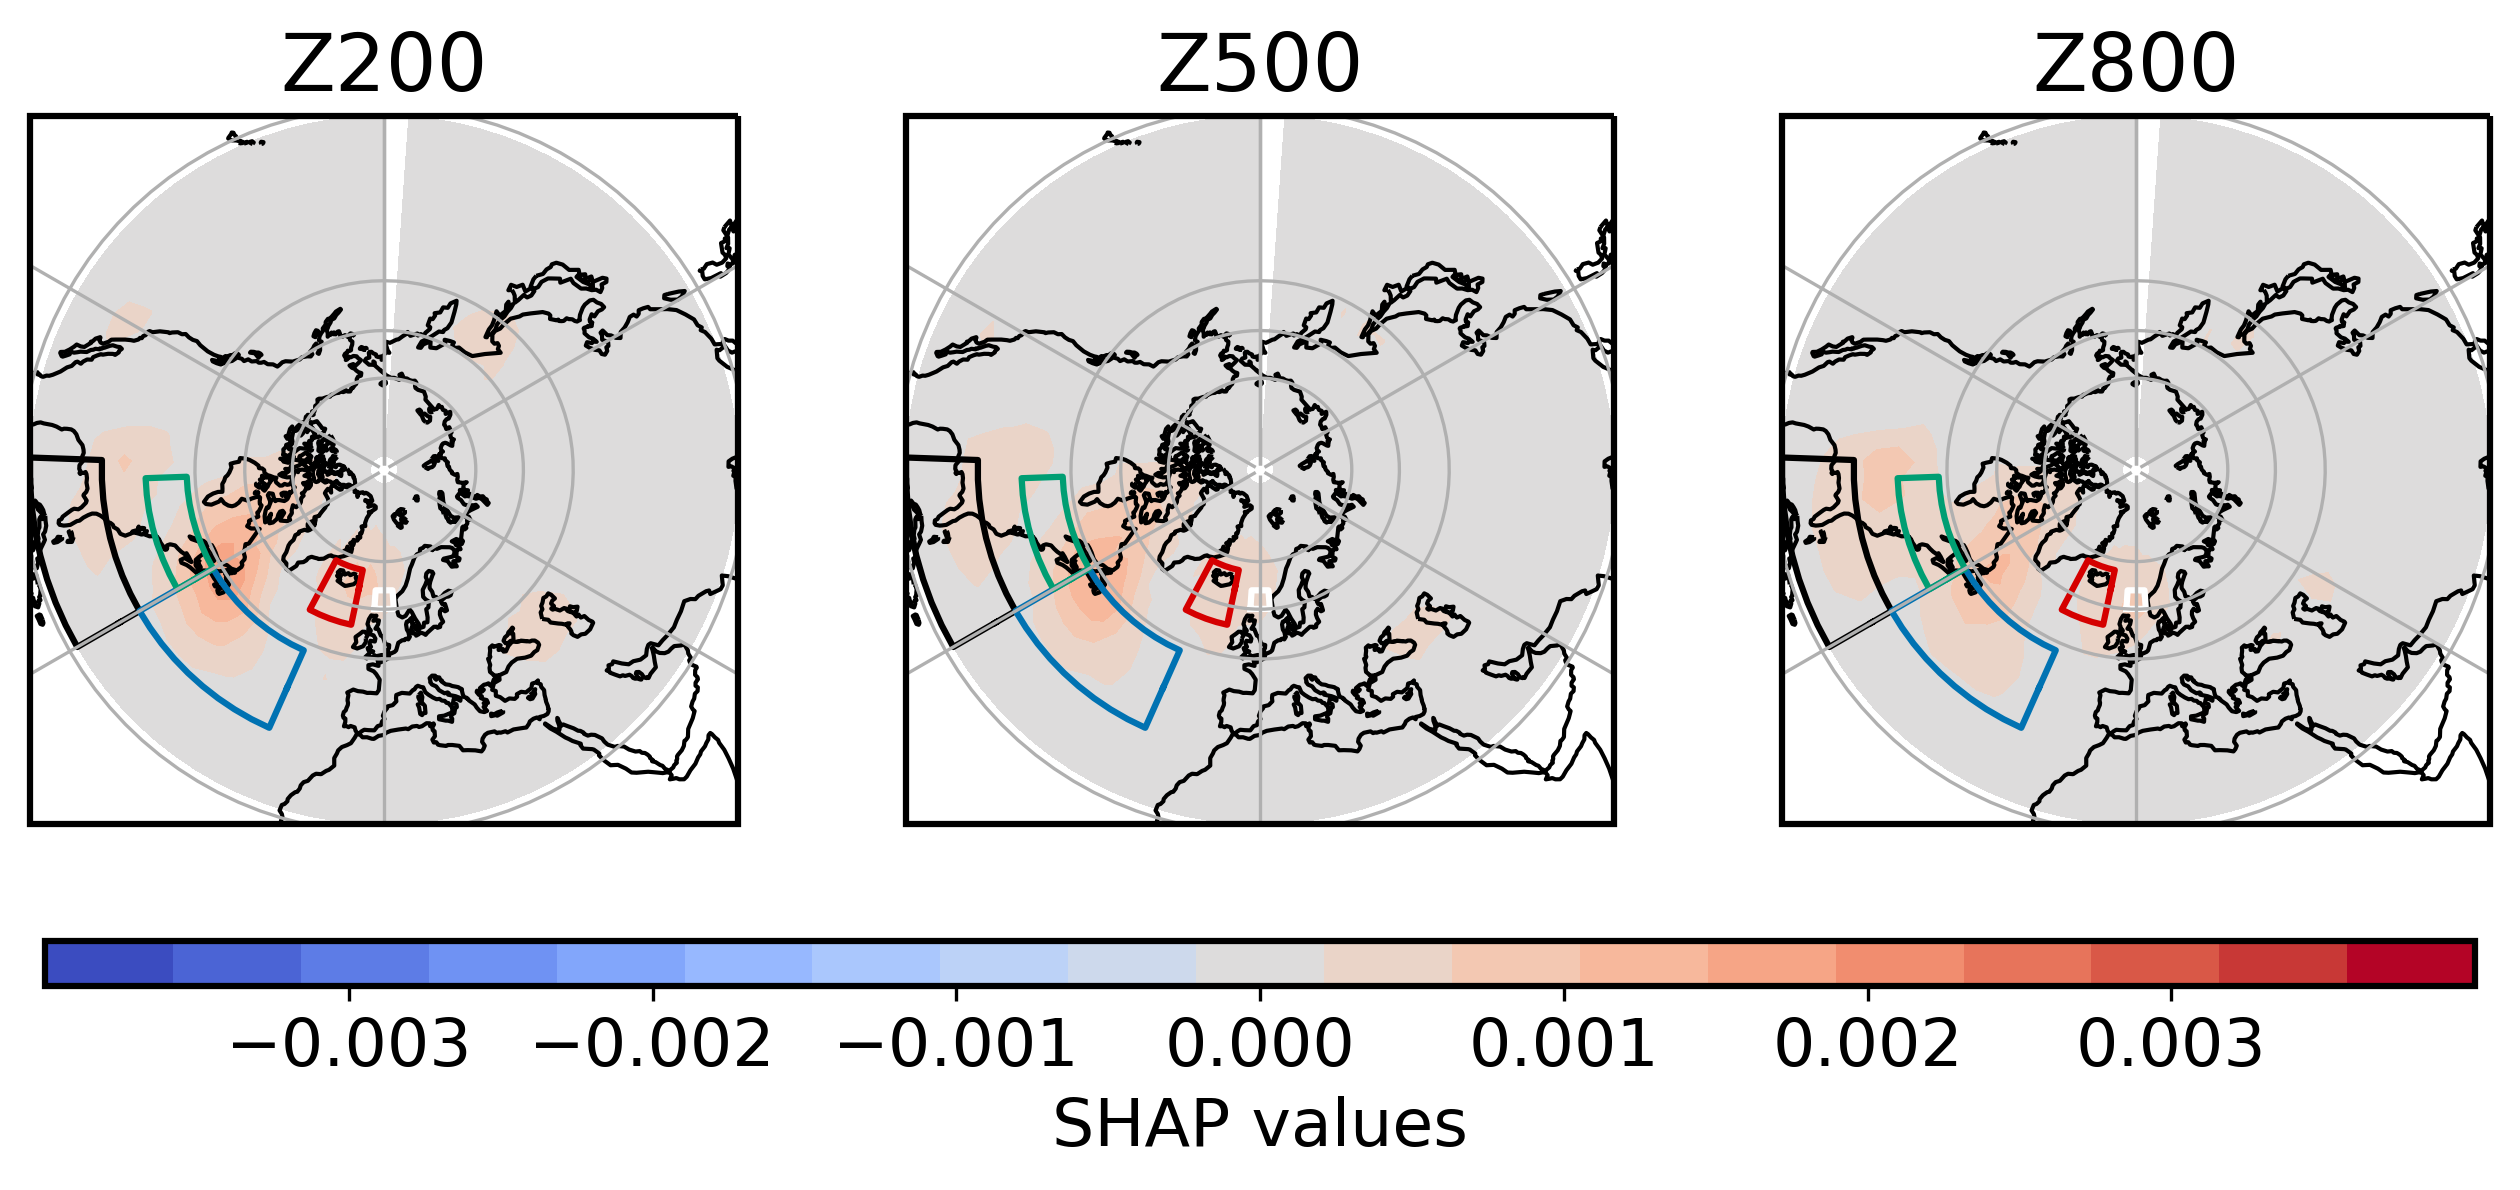

In [15]:

latitudes = np.load(dim_path+'dataX_lat.npy')
longitudes = np.load(dim_path+'dataX_lon.npy')
path="/scratch/hz1994/blocking/MMmodel/MMmodel/notebooks/All_paper_Jupyter_script/"
plot1_mean=np.load(path+"shap_DT.npy") 
fig1,ax=polorplot_levels(plot1_mean,latitudes,longitudes   ,minval=-0.001,maxval=0.004,iv=0.001)
lon_atl=[]
lat_atl=[]
lat_atl=[latitudes[10],latitudes[10],latitudes[11],latitudes[11],latitudes[10]]
lon_atl=[longitudes[44],longitudes[46],longitudes[46],longitudes[44],longitudes[44]]

ax=ax.flatten()
for a in ax:
    a.plot(lon_atl, lat_atl,'w',linestyle='-',alpha = 1,transform=ccrs.PlateCarree(), label='atl')

sq=True
str_sq=sq*"_sq"
ax=add_sq(sq,ax)


fig1.savefig(path+'Fig12_DT'+str_sq+'.png',dpi=300, bbox_inches="tight" )